# Photocurrent in $Al_x Ga_{1-x} As/GaAs$ quantum heterostructures


In [1]:
# python standard
import time

# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 12
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

# constants
au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## Parameters

In [2]:
N      = 2048
z_ang  = np.linspace(-250.0, 250.0, N) # Angstrom
z_au   = z_ang / au2ang

## Bound States

In [35]:
def orthonormal(n=2, size=2048):
    """
    Return the first `n` orthonormal legendre polynoms weighted by a gaussian
    They are useful as kickstart arrays for a imaginary time evolution

    Params
    ------
    n : int
        The number of arrays
    size : int
        The number of points in each array
    """
    sg  = np.linspace(-1, 1, size) # short grid
    g   = gaussian(size, std=int(size/100)) # gaussian
    vls = [g*legendre(i)(sg) for i in range(n)]
    return np.array(vls, dtype=np.complex_)


def fi(v, i):
    """
    short for flex_index, find the index `i` in array `v`
    `i` might be float, so that for `i = 1.5`, the return would be
    `(v[2]+v[1])/2`
    
    Params
    ------
    v : array_like
        a list of real or complex numbers
    i : int
        a semi integer number between 0 and the vector's `v` length
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0
    
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    where H = T + `V`, T is the only kinect operator in one dimension
    
    Params
    ------
    z : array_like
        the coordinates grid
    V : array_like
        the potential
    psi : array_like
        the wave function
    m : array_like
        the (position dependent) effective mass
    """
    dz    = z[1]-z[0]
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2)*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2)*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real
    
    
def bound_states(z, V, m, nmax=20, precision=1e-9):
    """
    find the bound eigenstates for a given potential `V` under the effective
    mass approximation (`m`)
    
    Params
    ------
    z : array_like
        the coordinates grid
    V : array_like
        the potential
    m : array_like
        the (position dependent) effective mass
    nmax : int
        since it uses the inverse interaction, it is the max number of
        kick start eigenvalues in a grid between `min(V)` and `max(V)`
    precision : float
        it is the max error allowed for each eigenvalue, the error is just
        (new_eigenalue_n - old_eigenalue_n)/old_eigenalue_n
    """
    
    forecast = np.linspace(np.min(V), np.max(V), nmax)
    dz  = z[1]-z[0]
    dz2 = dz**2
    
    # kick start eigenstates
    eigenstates = orthonormal(nmax, size=N)
    eigenvalues = np.zeros(nmax)
    
    # matrix diagonals
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    def get_invA(v_shift=0.0):
        for i in range(N):
            try:
                main_diag[i] = (0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5)) \
                    +(V[i]-v_shift)
            except:
                main_diag[i] = 0.0

            if i < N-1:
                sub_diag[i] = -(0.5/dz2)*(1.0/fi(m,i+0.5))

        diagonals = [main_diag, sub_diag, sub_diag]
        A         = diags(diagonals, [0, -1, 1]).toarray()
        return inv(A)
            
    counters = np.zeros(nmax)
    timers = np.zeros(nmax)
    precisions = np.zeros(nmax)
    vectors_sqeuclidean = np.zeros(nmax)
    
    for s in range(nmax):
        last_ev = 1.0
        last_es = np.zeros(N, dtype=np.complex_)
        
        shift = forecast[s]
        invA = get_invA(shift)
        V_shifted = V-shift
        
        while True:
            start_time = time.time()
            eigenstates[s] = invA.dot(eigenstates[s])
            counters[s] += 1

#             # gram-shimdt
#             for j in range(s):
#                 proj = simps(eigenstates[s]*eigenstates[j].conj(), z)
#                 eigenstates[s] -= proj * eigenstates[j]

            # normalize
            A = np.sqrt(simps(eigenstates[s]*eigenstates[s].conj(), z))
            eigenstates[s] /= A
            timers[s] += time.time() - start_time

            eigenvalues[s] = eigenvalue(z,V_shifted,eigenstates[s],m)+shift

            # check precision
            precisions[s] = np.abs(1-eigenvalues[s]/last_ev)
            last_ev = eigenvalues[s]

            if precisions[s] < precision:
                XA = [np.abs(eigenstates[s])**2]
                XB = [np.abs(last_es)**2]
                vectors_sqeuclidean[s] = cdist(XA, XB, 'sqeuclidean')[0][0]
                break

            last_es = np.copy(eigenstates[s])

    return {
        'eigenvalues': eigenvalues,
        'eigenstates': eigenstates,
        'counters': counters,
        'timers': timers,
        'precisions': precisions,
        'squared_euclidean_dist': vectors_sqeuclidean
    }

## Double Barrier Quantum Well

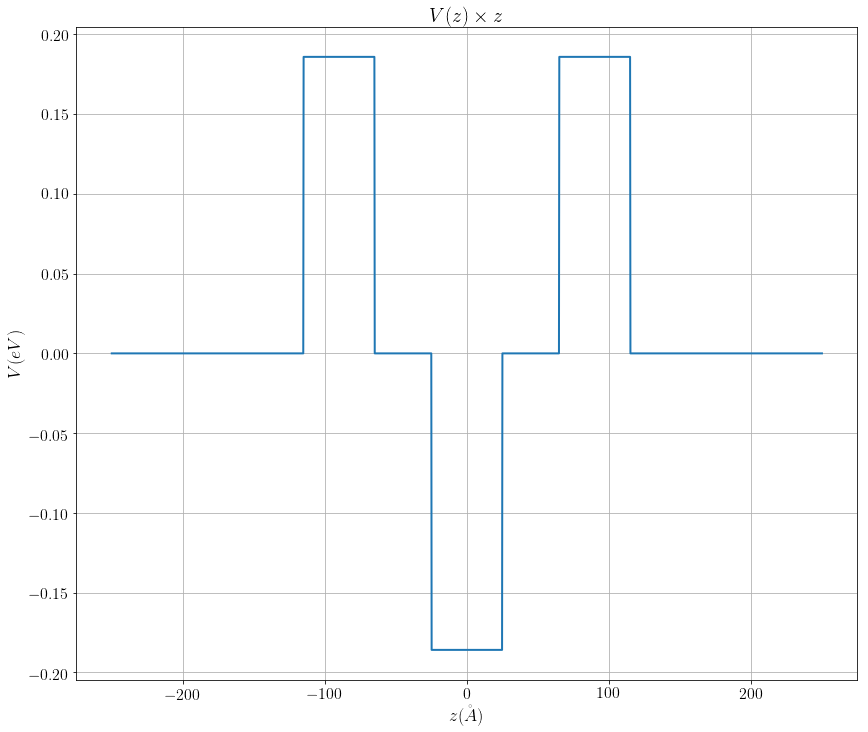

In [31]:
#g_algaas = lambda x: 1.519+1.447*x-0.15*x**2 # GAP
# Degani's actual potential
g_algaas = lambda x: 0.0 if x == 0.2 else (0.185897 if x == 0.4 else -0.185897)
m_algaas = lambda x: 0.067 + 0.083 * x # effective mass

xd       = 0.2 # displacement
xb       = 0.4 # barrier
xw       = 0.0 # well
wl       = 50.0 # Angstrom
bl       = 50.0 # Angstrom
dl       = 40.0 # Angstrom
CBO      = 0.655
VBO      = 0.345

def x_shape(z):
    if np.abs(z) < wl/2:
        return xw
    elif np.abs(z) < wl/2+dl:
        return xd
    elif np.abs(z) < wl/2+dl+bl:
        return xb
    return xd

V        = np.vectorize(lambda z: g_algaas(x_shape(z)))(z_ang)#*CBO
V       -= g_algaas(xd)#*CBO
#meff     = np.vectorize(lambda z: m_algaas(x_shape(z)))(z_ang)
# Degani's actual effective mass
meff     = np.vectorize(lambda z: m_algaas(xw))(z_ang)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V)
ax.set_title(r"$V(z) \times z$")
ax.grid(True)
plt.show()

## Potential and Coordinates grid in atomic units

In [32]:
V_au = V / au2ev
z_au = z_ang / au2ang

## Eigenvalues

In [33]:
res = bound_states(z_au, V_au, meff)
for i, eigenvalue in enumerate(res['eigenvalues']):
    value  = eigenvalue * au2ev # in eV
    print(r"E_%02d = %.8f eV" % (i, value))

E_00 = -0.11224916 eV
E_01 = -0.11224916 eV
E_02 = -0.11224916 eV
E_03 = -0.11224916 eV
E_04 = -0.11224916 eV
E_05 = -0.11224916 eV
E_06 = -0.11224916 eV
E_07 = -0.11224916 eV
E_08 = 0.02392574 eV
E_09 = 0.02392574 eV
E_10 = 0.02392574 eV
E_11 = 0.02392574 eV
E_12 = 0.04097271 eV
E_13 = 0.09317542 eV
E_14 = 0.09317542 eV
E_15 = 0.09317542 eV
E_16 = 0.13510599 eV
E_17 = 0.13510599 eV
E_18 = 0.13510599 eV
E_19 = 0.20588686 eV


## Eigenstates

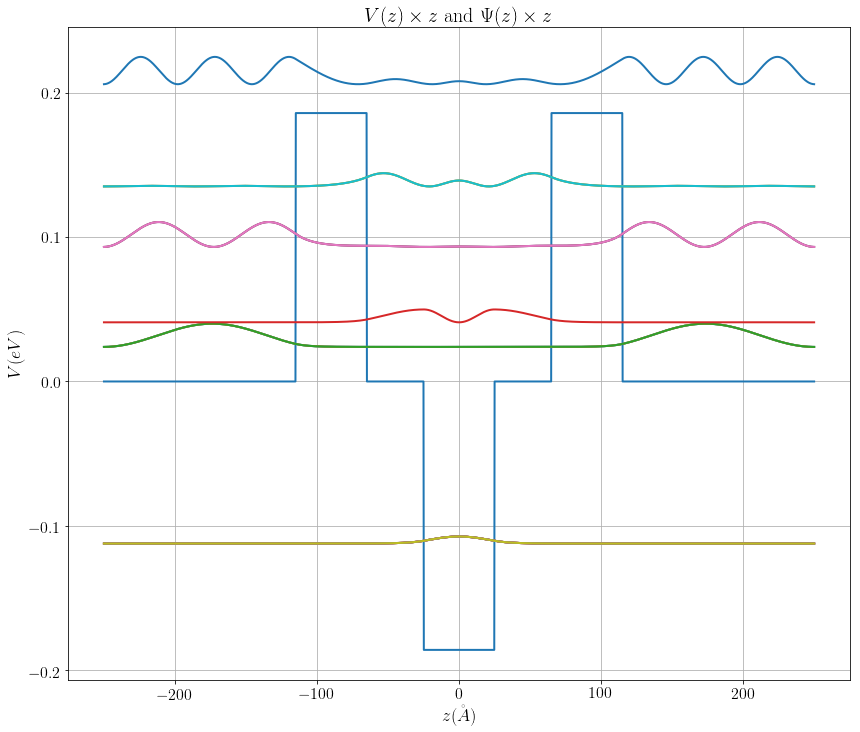

In [34]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$z (\AA)$')
ax.set_ylabel(r'$V (eV)$')
ax.plot(z_ang, V)

eigenstates = res['eigenstates'].copy()
for i, eigenstate in enumerate(eigenstates):
    # # change from au to ang
    #eigenstate /= np.sqrt(simps(eigenstate.conj()*eigenstate, z_ang))
    eigenstate *= np.ptp(V) / np.ptp(np.abs(eigenstate)**2)/50.0
    psi = (np.abs(eigenstate)**2).real + res['eigenvalues'][i]* au2ev
    ax.plot(z_ang, psi)

ax.set_title(r"$V(z) \times z$ and $\Psi(z) \times z$")
ax.grid(True)
ax.legend()
plt.show()